# Compute changepoints for a dataset before and after transformation

In [26]:
import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from toolz.curried import get, pluck
from toolz import groupby, valmap, compose, curry, partial
from aging.size_norm.data import clean
from aging.behavior.scalars import compute_scalars, im_moment_features
from sklearn.random_projection import GaussianRandomProjection
from scipy.ndimage import gaussian_filter, shift, rotate
from aging.plotting import (
    format_plots,
    PlotConfig,
    save_factory,
    figure,
    legend,
    IMG_KWARGS,
)

In [21]:
super_clean = partial(clean, height_thresh=14, tail_ksize=7, dilation_ksize=4)

In [46]:
def alignment_function(frame, recon_frame):
    filt_frame = gaussian_filter(super_clean(frame).astype("float32"), 13)
    filt_recon_frame = gaussian_filter(recon_frame.astype("float32"), 13)

    raw_peak = np.array(np.unravel_index(np.argmax(filt_frame), filt_frame.shape))
    recon_peak = np.array(
        np.unravel_index(np.argmax(filt_recon_frame), filt_recon_frame.shape)
    )

    translated = shift(super_clean(frame), recon_peak - raw_peak)

    moments = im_moment_features(translated)
    return rotate(translated, -np.rad2deg(moments["orientation"]), reshape=False).astype(
        "uint8"
    )

In [2]:
def get_name(file):
    with h5py.File(file, "r") as h5f:
        return h5f["metadata/acquisition/SessionName"][()].decode()

In [3]:
recon_key = "win_size_norm_frames_v4"

In [4]:
@curry
def has_key(key, file):
    with h5py.File(file, "r") as h5f:
        return key in h5f

In [5]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False)

In [6]:
pattern = re.compile(r"(\d{1,2}[wm])")

folder = Path(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_05/all_data_pca/Ontogeny_males"
)
files = sorted(filter(has_key(recon_key), folder.glob("*.h5")))
names = list(map(get_name, files))
ages = [pattern.search(n).group(0) for n in names]
groups = groupby(get(0), list(zip(ages, files)))
groups = valmap(compose(list, pluck(1)), groups)

In [7]:
def zscore(arr):
    return (arr - arr.mean(axis=0, keepdims=True)) / arr.std(axis=0, keepdims=True)

## Test with example file

In [8]:
file = groups['3m'][0]
with h5py.File(file, 'r') as h5f:
    frames = np.array(list(map(clean, h5f['frames'][()])))
    transformed_frames = h5f[recon_key][()].astype('uint8')
mdl = GaussianRandomProjection(n_components=200)
proj = mdl.fit_transform(frames.reshape(len(frames), -1))
proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

In [9]:
proj.shape

(53904, 200)

In [10]:
k = 5
sig = 3

In [11]:
proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
proj_df_smooth = (
    proj_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff = np.square(proj_df_smooth.diff(k))

proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
proj_t_df_smooth = (
    proj_t_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff_t = np.square(proj_t_df_smooth.diff(k))

cp = squared_diff.mean(axis="columns")
cp_t = squared_diff_t.mean(axis="columns")

In [12]:
# how many frames to plot
n_frames = 750

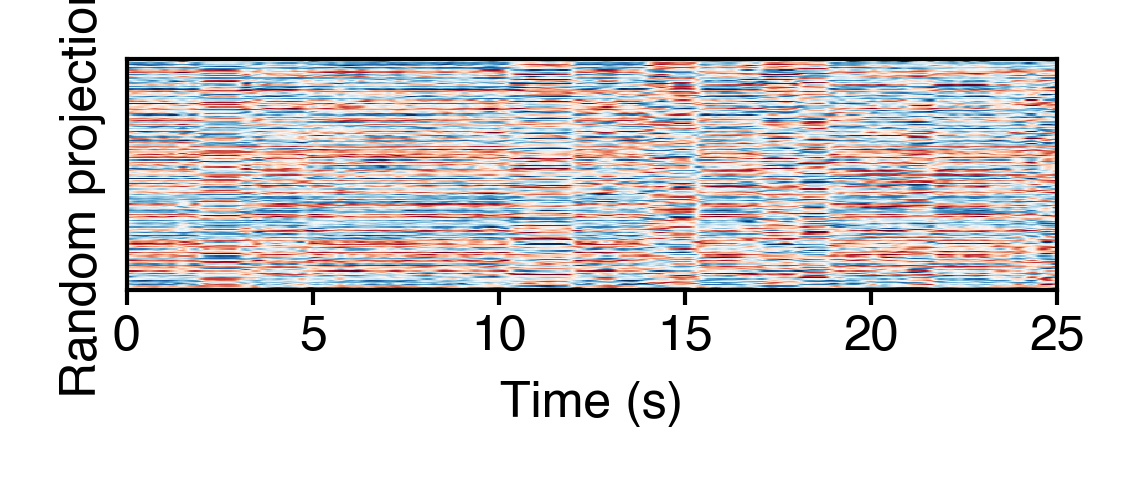

In [13]:
fig = figure(2, 0.5)
plt.imshow(
    proj_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
saver(fig, "rps-3m-raw");

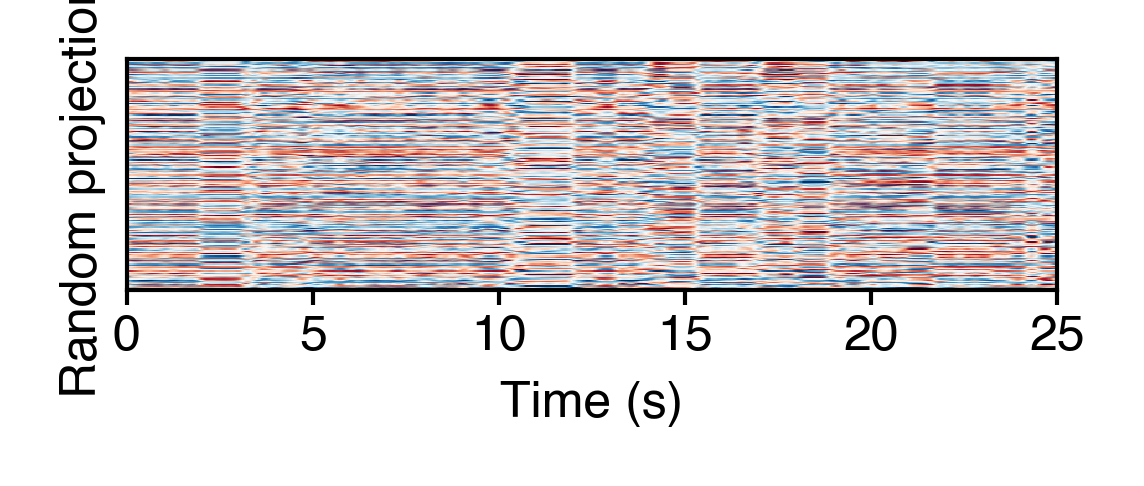

In [14]:
fig = figure(2, 0.5)
plt.imshow(
    proj_t_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
saver(fig, "rps-3m-transformed");

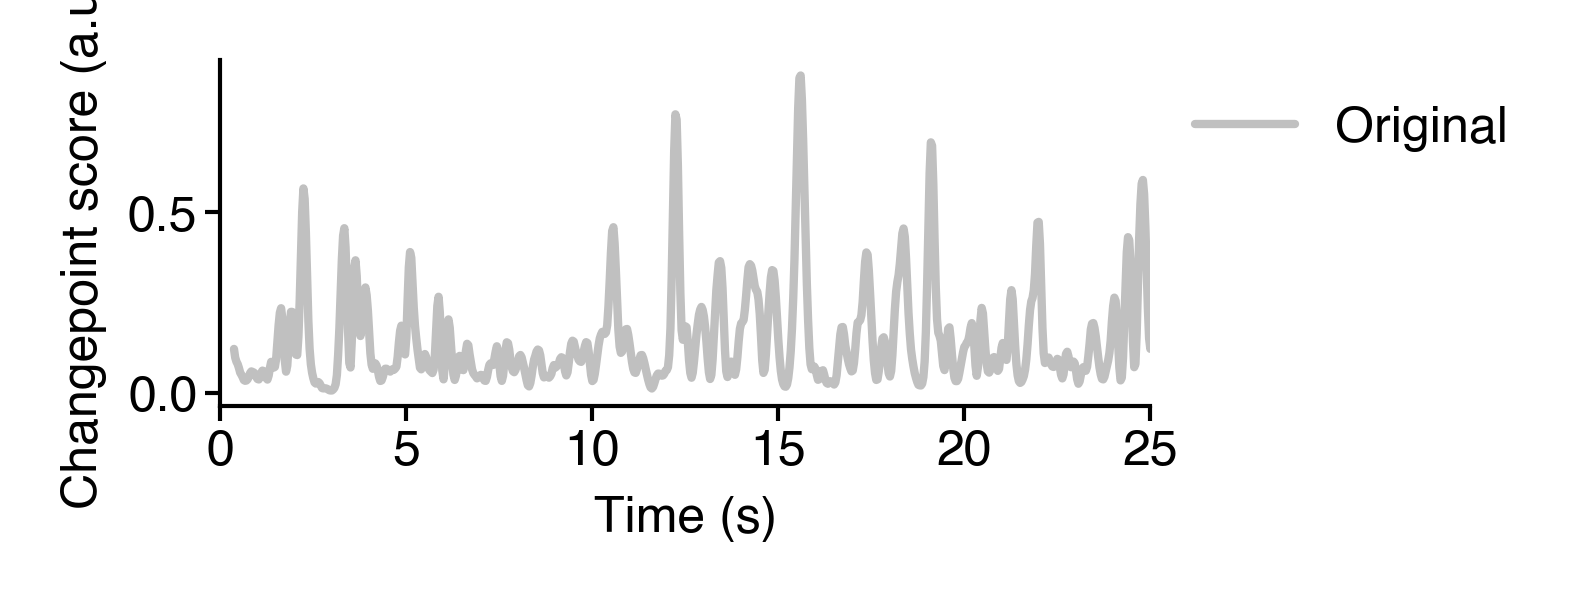

In [15]:
fig = figure(2, 0.75)
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3m-orig');

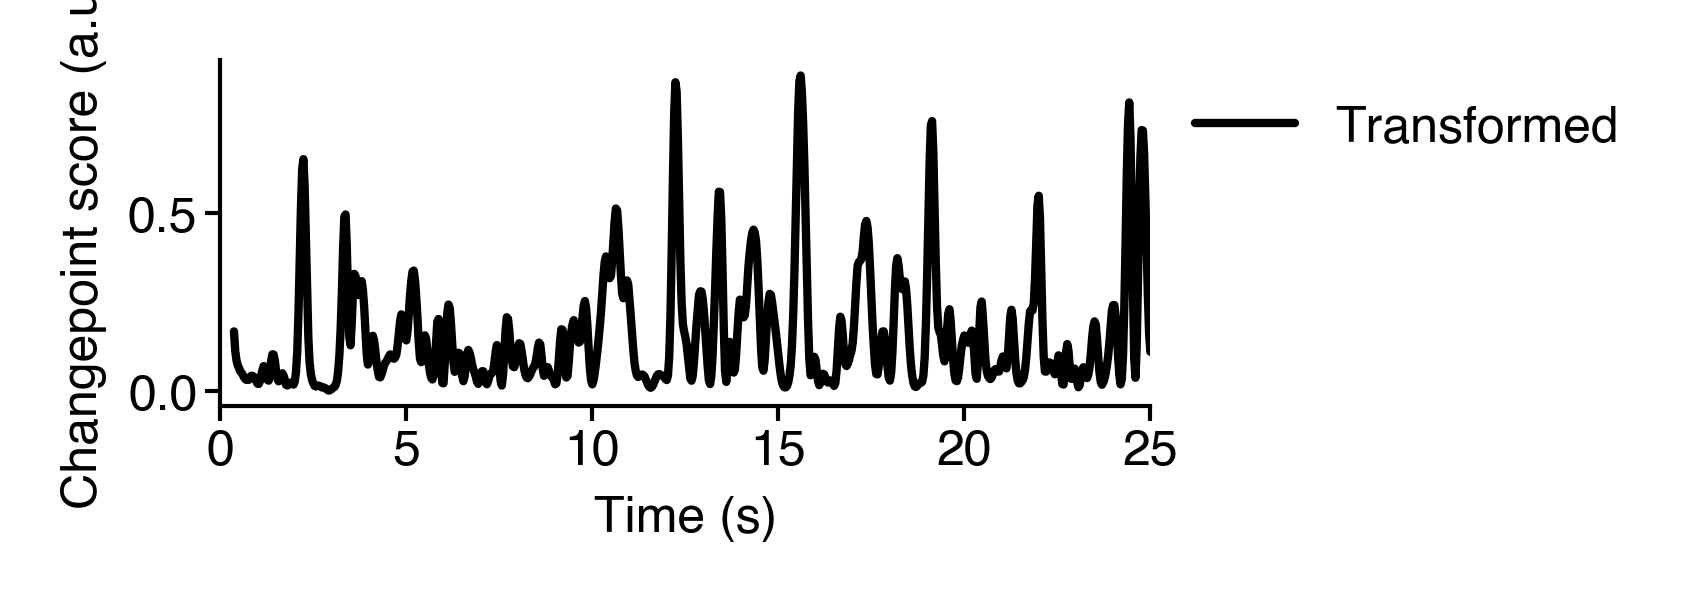

In [16]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3m-trans');

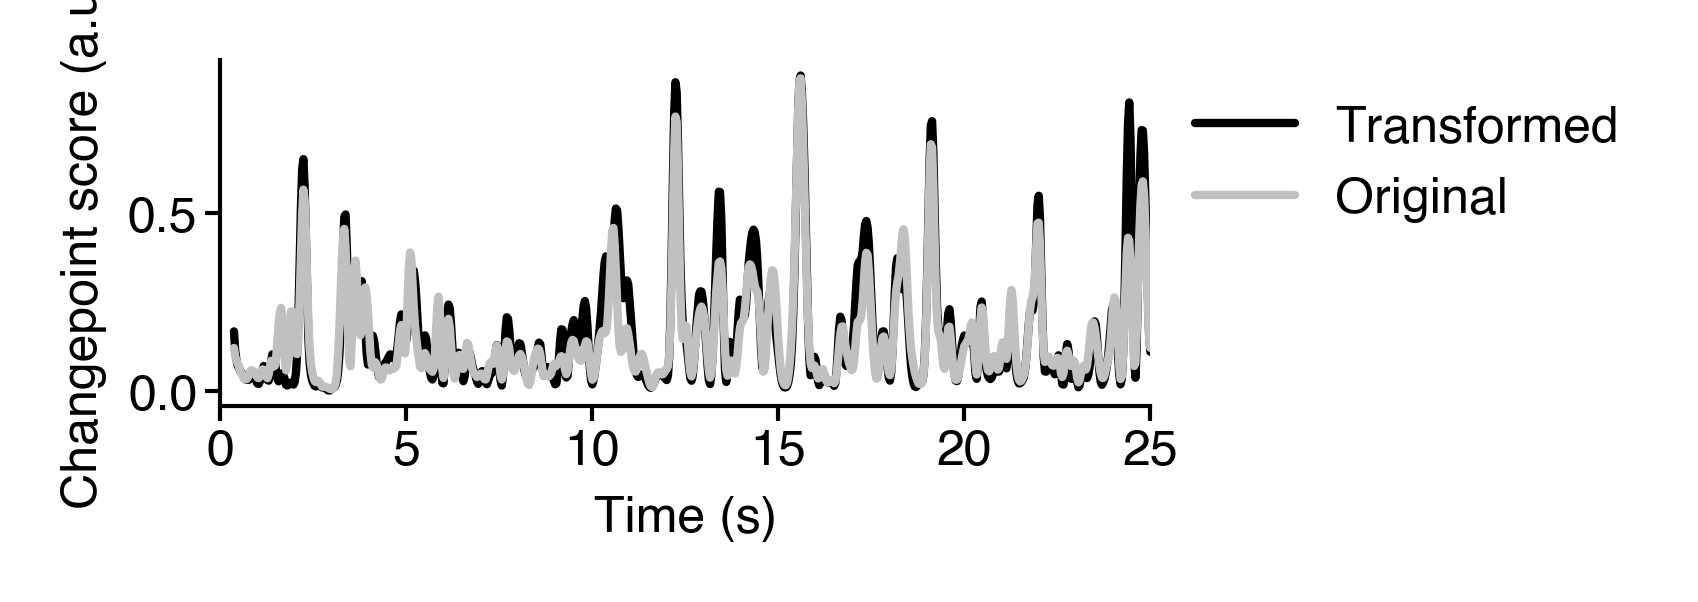

In [17]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3m');

In [18]:
cp.corr(cp_t)

0.9601831331377874

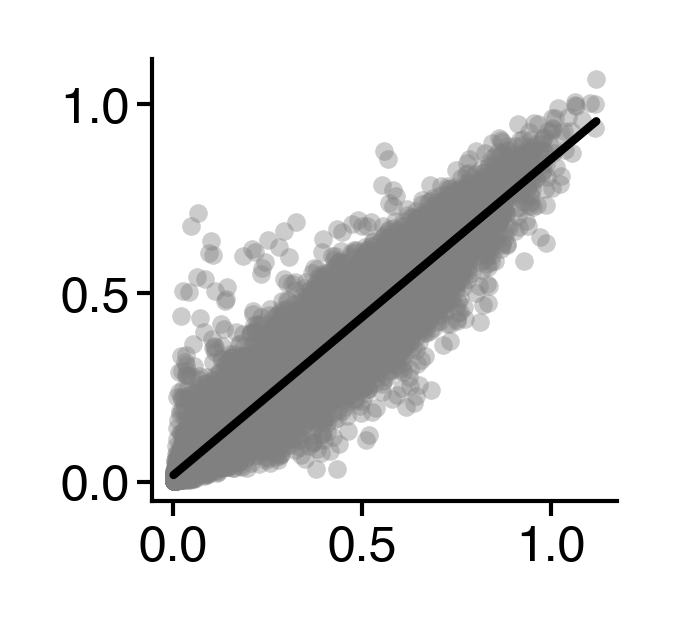

In [19]:
fig = figure(1, 1)
ax = sns.regplot(
    x=squared_diff_t.mean(axis="columns"),
    y=squared_diff.mean(axis="columns"),
    color="k",
    scatter_kws=dict(lw=0, alpha=0.4, s=5, color="gray"),
    line_kws=dict(lw=1),
)
ax.set_aspect("equal")
sns.despine()

## Another example

In [18]:
from toolz import partial

In [ ]:
file = groups['18m'][1]
with h5py.File(file, 'r') as h5f:
    frames = np.array(list(map(partial(clean, height_thresh=15), h5f['frames'][()])))
    for i, frame in enumerate(frames):
        moments = im_moment_features(frame)
        if moments is not None:
            frames[i] = rotate(frame, -np.rad2deg(moments['orientation']), reshape=False).astype('uint8')
    transformed_frames = h5f[recon_key][()].astype('uint8')
mdl = GaussianRandomProjection(n_components=200)
proj = mdl.fit_transform(frames.reshape(len(frames), -1))
proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

In [ ]:
proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
proj_df_smooth = proj_df.rolling(sig * 4, win_type='gaussian', center=True).mean(std=sig).dropna()
squared_diff = np.square(proj_df_smooth.diff(k))

proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
proj_t_df_smooth = proj_t_df.rolling(sig * 4, win_type='gaussian', center=True).mean(std=sig).dropna()
squared_diff_t = np.square(proj_t_df_smooth.diff(k))

cp = squared_diff.mean(axis='columns')
cp_t = squared_diff_t.mean(axis='columns')

In [ ]:
fig = figure(2, 0.5)
plt.imshow(
    proj_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel='Time (s)', ylabel='Random projections')
saver(fig, 'rps-18m-raw');

In [ ]:
fig = figure(2, 0.5)
plt.imshow(
    proj_t_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel='Time (s)', ylabel='Random projections')
saver(fig, 'rps-18m-transformed');

In [ ]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='gray', label='Transformed')
plt.plot(cp.iloc[:n_frames], color='k', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-18m');

In [ ]:
cp.corr(cp_t)

## Example for 3 weeks

In [ ]:
file = groups['3w'][0]
with h5py.File(file, 'r') as h5f:
    frames = np.array(list(map(partial(clean, height_thresh=15), h5f['frames'][()])))
    for i, frame in enumerate(frames):
        moments = im_moment_features(frame)
        if moments is not None:
            frames[i] = rotate(frame, -np.rad2deg(moments['orientation']), reshape=False).astype('uint8')
    transformed_frames = h5f[recon_key][()].astype('uint8')
mdl = GaussianRandomProjection(n_components=200)
proj = mdl.fit_transform(frames.reshape(len(frames), -1))
proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

In [ ]:
proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
proj_df_smooth = proj_df.rolling(sig * 4, win_type='gaussian', center=True).mean(std=sig).dropna()
squared_diff = np.square(proj_df_smooth.diff(k))

proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
proj_t_df_smooth = proj_t_df.rolling(sig * 4, win_type='gaussian', center=True).mean(std=sig).dropna()
squared_diff_t = np.square(proj_t_df_smooth.diff(k))

cp = squared_diff.mean(axis='columns')
cp_t = squared_diff_t.mean(axis='columns')

In [ ]:
fig = figure(2, 0.5)
plt.imshow(
    proj_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel='Time (s)', ylabel='Random projections')
saver(fig, 'rps-3w-raw');

In [ ]:
fig = figure(2, 0.5)
plt.imshow(
    proj_t_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel='Time (s)', ylabel='Random projections')
saver(fig, 'rps-3w-transformed');

In [ ]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='gray', label='Transformed')
plt.plot(cp.iloc[:n_frames], color='k', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3w');

In [ ]:
cp.corr(cp_t)

## Compute correlation between changepoint scores for all ages

In [ ]:
k = 5
sig = 3

In [ ]:
age_map = {
    "12m": 12 * 30 / 7,
    "18m": 18 * 30 / 7,
    "3w": 3,
    "5w": 5,
    "9w": 9,
    "7w": 7,
    "90w": 90,
    "22m": 22 * 30 / 7,
    "3m": 3 * 30 / 7,
    "6m": 6 * 30 / 7,
    "9m": 9 * 30 / 7,
}
age_map = valmap(compose(int, round), age_map)

In [ ]:
total_frames = 8000
cp_dict = defaultdict(list)
for i in tqdm(range(16)):
    for age, v in tqdm(groups.items()):
        with h5py.File(v[i], 'r') as h5f:
            frames = np.array(list(map(partial(clean, height_thresh=15), h5f['frames'][:total_frames])))
            for j, frame in enumerate(frames):
                moments = im_moment_features(frame)
                if moments is not None:
                    frames[j] = rotate(frame, -np.rad2deg(moments['orientation']), reshape=False).astype('uint8')
            transformed_frames = h5f[recon_key][:total_frames].astype('uint8')
        mdl = GaussianRandomProjection(n_components=200, random_state=0)
        proj = mdl.fit_transform(frames.reshape(len(frames), -1))
        proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

        proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
        proj_df_smooth = proj_df.rolling(sig * 4, win_type='gaussian', center=True).mean(std=sig).dropna()
        squared_diff = np.square(proj_df_smooth.diff(k))

        proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
        proj_t_df_smooth = proj_t_df.rolling(sig * 4, win_type='gaussian', center=True).mean(std=sig).dropna()
        squared_diff_t = np.square(proj_t_df_smooth.diff(k))

        cp = squared_diff.mean(axis='columns')
        cp_t = squared_diff_t.mean(axis='columns')

        cp_dict[age_map[age]].append(cp.corr(cp_t))

In [ ]:
cp_df = pd.DataFrame(cp_dict)
cp_df = cp_df.melt(var_name="Age", value_name="corr")

In [ ]:
fig = figure(1, 2)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="Age",
    palette="crest_r",
    size=2.2,
    legend='full',
)
legend(ax, title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel='Changepoint score correlation')
sns.despine()
saver(fig, 'cps-correlation-vs-age-swarmplot');